In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from numpy.linalg import pinv
import xgboost as xgb
from sklearn.linear_model import SGDRegressor, LinearRegression

In [7]:
data = pd.read_csv('data_new.csv')
data

DES   HBA  HBD   MR     T/K    Dexp     MCI  Tbm     Tcm     Vcm  \
0     DES2  ChCl   EG  1.2  308.57  1.1163  1.7208  439  610.73  290.69   
1     DES2  ChCl   EG  1.2  312.56  1.1142  1.7208  439  610.73  290.69   
2     DES2  ChCl   EG  1.2  313.52  1.1137  1.7208  439  610.73  290.69   
3     DES2  ChCl   EG  1.2  317.27  1.1116  1.7208  439  610.73  290.69   
4     DES2  ChCl   EG  1.2  319.62  1.1101  1.7208  439  610.73  290.69   
..     ...   ...  ...  ...     ...     ...     ...  ...     ...     ...   
489  DES45  TBAB  TEG  1.5  336.14  1.0469  8.4242  579  780.70  702.54   
490  DES45  TBAB  TEG  1.5  340.21  1.0441  8.4242  579  780.70  702.54   
491  DES45  TBAB  TEG  1.5  343.16  1.0422  8.4242  579  780.70  702.54   
492  DES45  TBAB  TEG  1.5  349.41  1.0384  8.4242  579  780.70  702.54   
493  DES45  TBAB  TEG  1.5  352.32  1.0370  8.4242  579  780.70  702.54   

       Pcm    ωm        MW  
0    59.92  0.94   87.6648  
1    59.92  0.94   87.6648  
2    59.92  0.94   87.6648  
3    59.92  0.94   87.6648  
4    59.92  0.94   87.6648  
..     ...   ...       ...  
489  31.24  1.07  177.7200  
490  31.24  1.07  177.7200  
491  31.24  1.07  177.7200  
492  31.24  1.07  177.7200  
493  31.24  1.07  177.7200  

[494 rows x 13 columns]

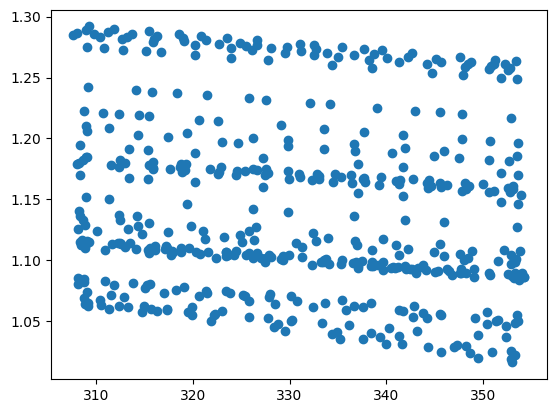

In [11]:
from matplotlib import pyplot as plt
temp = data.iloc[:,4]
density = data.iloc[:,5]
plt.scatter(temp,density)
plt.show()

In [12]:
X = data[['MR','T/K','MCI','ωm','MW']]
y = data['Dexp']
print(X.shape, y.shape)

(494, 5) (494,)


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
y_test = y_test.to_numpy()

In [14]:
# Without Regularization

lr = LinearRegression()
lr.fit(X_train, y_train)

pred = lr.predict(X_test)

sum = 0
for i in range(len(pred)):
    sum += abs(pred[i] - y_test[i]) / y_test[i]
mape = sum / len(y_test)
print(f'MAPE: {mape*100}')
print(f'Accuracy: {(1 - mape)*100}')

MAPE: 4.284499600109704
Accuracy: 95.7155003998903


In [16]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

objectives = ['reg:gamma', 'reg:squarederror', 'reg:squaredlogerror', 'reg:tweedie', 'reg:pseudohubererror']

for obj in objectives:
    params = {
        'objective': obj,
        'eval_metric': 'mape',
        'seed': 42
    }

    model = xgb.train(params, dtrain, 1000)
    pred = model.predict(dtest)

    sum = 0
    for i in range(len(pred)):
        sum += abs(pred[i] - y_test[i]) / y_test[i]
    mape = sum / len(y_test)
    print(f'\nObjective: {obj}')
    print(f'MAPE: {mape*100}')
    print(f'Accuracy: {(1 - mape)*100}\n')


Objective: reg:gamma
MAPE: 0.1563255628536928
Accuracy: 99.84367443714632

Objective: reg:squarederror
MAPE: 0.17814390048338696
Accuracy: 99.82185609951661

Objective: reg:squaredlogerror
MAPE: 0.2932922109955712
Accuracy: 99.70670778900444

Objective: reg:tweedie
MAPE: 0.16529529824158784
Accuracy: 99.83470470175841


Objective: reg:pseudohubererror
MAPE: 0.2204636926483211
Accuracy: 99.77953630735168


In [17]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:absoluteerror',
    'eval_metric': 'mae',             # Mean Absolute Error
    'seed': 42
}

model = xgb.train(params, dtrain, 100)
pred = model.predict(dtest)

sum = 0
for i in range(len(pred)):
    sum += abs(pred[i] - y_test[i]) / y_test[i]
mape = sum / len(y_test)
print(f'MAPE: {mape*100}')
print(f'Accuracy: {(1 - mape)*100}')

MAPE: 0.4383796025761476
Accuracy: 99.56162039742385


In [18]:
xtx = np.dot(X_train.T, X_train)
xty = np.dot(X_train.T, y_train)

xtxi = pinv(xtx)        # Psuedo Inverse (if inverse does not exist)

theta = np.dot(xtxi, xty)

pred = np.dot(theta, X_test.T)

sum = 0
for i in range(len(pred)):
    sum += abs(pred[i] - y_test[i]) / y_test[i]
mape = sum / len(y_test)
print(f'MAPE: {mape*100}')
print(f'Accuracy: {(1 - mape)*100}')

MAPE: 5.441121444118413
Accuracy: 94.55887855588159


In [19]:
from sklearn.model_selection import cross_val_predict
# 5 Fold Cross Validation with Normal Equation Method

from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, random_state=42, shuffle=True)
lr = LinearRegression()
lr.fit(X_train, y_train)

pred2 = cross_val_predict(lr, X_test, y_test, cv=kf)

sum = 0
for i in range(len(pred2)):
    sum += abs(pred2[i] - y_test[i]) / y_test[i]
mape = sum / len(y_test)
print(f'MAPE: {mape*100}')
print(f'Accuracy: {(1 - mape)*100}')

MAPE: 4.2586793257220465
Accuracy: 95.74132067427796


In [22]:
# Lasso

from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, random_state=42, shuffle=True)
lr = Lasso(alpha=0.5)

pred3 = cross_val_score(lr, X, y, cv=kf)

sum = 0
for i in range(len(pred3)):
    sum += abs(pred3[i] - y_test[i]) / y_test[i]
mape = sum / len(y_test)
print(f'MAPE: {mape*100}')
print(f'Accuracy: {(1 - mape)*100}')

MAPE: 5.110577633875088
Accuracy: 94.8894223661249


In [23]:
# Ridge

from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, random_state=42, shuffle=True)
lr = Ridge(alpha=0.5)

pred4 = cross_val_score(lr, X, y, cv=kf)

sum = 0
for i in range(len(pred4)):
    sum += abs(pred4[i] - y_test[i]) / y_test[i]
mape = sum / len(y_test)
print(f'MAPE: {mape*100}')
print(f'Accuracy: {(1 - mape)*100}')

MAPE: 4.0914301388617735
Accuracy: 95.90856986113823
